# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

# Trabalho A1 — Séries Temporais
---
### Integrantes
- Guilherme Carvalho
- Guilherme Buss
- Gustavo Bianchi
- João Gabriel
- Luís Felipe Marciano
- Vinícius Nascimento

### Objetivos
- Carregar e analisar data.csv
- Implementar baselines (mean, naive, seasonal naive, drift)
- Testar transformações (Box-Cox / log)
- Decompor série em tendência e sazonalidade
- Criar covariáveis (tempo, dummies sazonais, sen/cos, lags, rollings)
- Ajustar modelos de regressão linear múltipla
- Diagnosticar resíduos (ACF, Ljung-Box)
- Comparar usando métricas: MAE, RMSE, MAPE, MASE

---

## **Importação das bibliotecas**

In [44]:
# básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from datetime import datetime

# para modelos 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# para decomposição e testes
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

---

## **Pré-visualização dos dados**

In [45]:
df = pd.read_csv("data.csv")

df['week'] = pd.to_datetime(df['week']) # converter week para datetime
df = df.sort_values('week').reset_index(drop=True) # ordenar por data e reset index
df = df.set_index('week')

# checar informações
print(df.info())
print('Tamanho da série:', len(df))
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2022-10-31 to 2025-09-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  150 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
None
Tamanho da série: 150
            volume
week              
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23


---

## **Análise inicial dos dados de `volume`**

Antes de iniciar a modelagem, realizamos uma análise descritiva da variável `volume` para compreender sua forma e dispersão de suas amostras.

#### **Centralidade**

* *Média:* O valor médio de `volume` ao longo de todo o período. 
* *Mediana:* O valor que divide a série em duas metades, mais robusta a outliers.

#### **Dispersão**

* *Desvio Padrão:* Grau de dispersão médio dos dados em relação à média.
* *Variância:* É o quadrado do desvio padrão. 

#### **Forma da Distribuição**

* *Assimetria (Skewness):* Mede a falta de simetria da distribuição.
    * `~ 0`: Distribuição aproximadamente simétrica.
    * `> 0`: Assimetria positiva (à direita). A cauda direita da distribuição é mais longa, e a média tende a ser maior que a mediana.
    * `< 0`: Assimetria negativa (à esquerda). A cauda esquerda é mais longa, e a média tende a ser menor que a mediana.

#### **Valores Extremos**

* *Mínimo e Máximo:* Os menores e maiores valores de `volume` observados na série. Ajudam a entender a amplitude total dos dados.

In [46]:
# Métricas iniciais
mean = np.mean(df["volume"])
median = np.median(df["volume"])

std = np.std(df["volume"])
variance = np.var(df["volume"])

skewness = stats.skew(df["volume"])

max_df = np.max(df["volume"])
min_df = np.min(df["volume"])
range_df = max_df - min_df

In [47]:
print("- VARIÁVEL VOLUME - " * 5)
print("-" * 100)

print("--- Tendência Central ---")
print(f"{'Média:':<25} {mean:,.2f}")
print(f"{'Mediana:':<25} {median:,.2f}")

print("\n--- Dispersão ---")
print(f"{'Desvio Padrão:':<25} {std:,.2f}")
print(f"{'Variância:':<25} {variance:,.2f}")

print("\n--- Forma da Distribuição ---")
print(f"{'Assimetria (Skewness):':<25} {skewness:.4f}")

print("\n--- Valores Extremos ---")
print(f"{'Valor Mínimo:':<25} {min_df:,.2f}")
print(f"{'Valor Máximo:':<25} {max_df:,.2f}")
print(f"{'Amplitude (Range):':<25} {range_df:,.2f}")

print("-" * 100)

- VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - 
----------------------------------------------------------------------------------------------------
--- Tendência Central ---
Média:                    4.12
Mediana:                  3.00

--- Dispersão ---
Desvio Padrão:            4.04
Variância:                16.32

--- Forma da Distribuição ---
Assimetria (Skewness):    1.0339

--- Valores Extremos ---
Valor Mínimo:             0.14
Valor Máximo:             16.59
Amplitude (Range):        16.45
----------------------------------------------------------------------------------------------------


A análise nos mostra que a série de volume não é 'bem comportada'. Ela tem uma forte assimetria positiva e alta volatilidade. Futuramente, veremos através do gráfico que o grande causador disso seria reflexo da presença de picos em valores elevados. Essa observação que fizemos sugere a possivel necessidade de uma transformação de variável (como a logarítmica) antes da modelagem, o que pode estabilizar a variância e tornar a distribuição mais simétrica, o que tende a melhorar o ajuste e o poder preditivo de modelos de regressão.

---

## **Análise de *Estacionariedade* da série temporal**

A estacionariedade é uma premissa fundamental para muitos modelos de séries temporais. Uma série é dita estacionária se suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Nesta seção, investigamos se a série de `volume` atende a essa premissa através de análise visual e do teste estatístico de Dickey-Fuller Aumentado (ADF).

### **Inspeção Visual**

Verificaremos através de visualizações se a série é ou não estacionária:

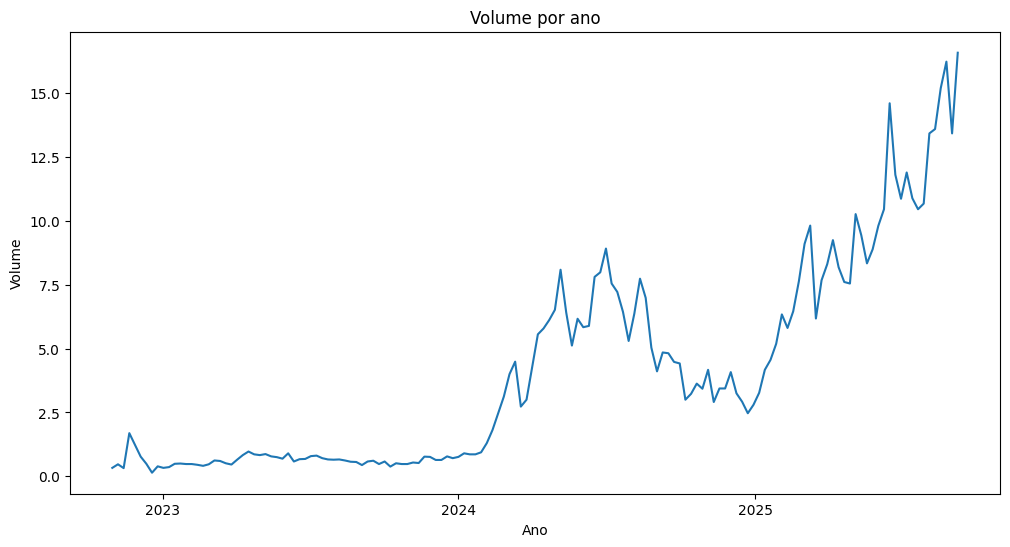

In [48]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume'])

# mostrar apenas os anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Volume")
plt.title("Volume por ano")
plt.show()

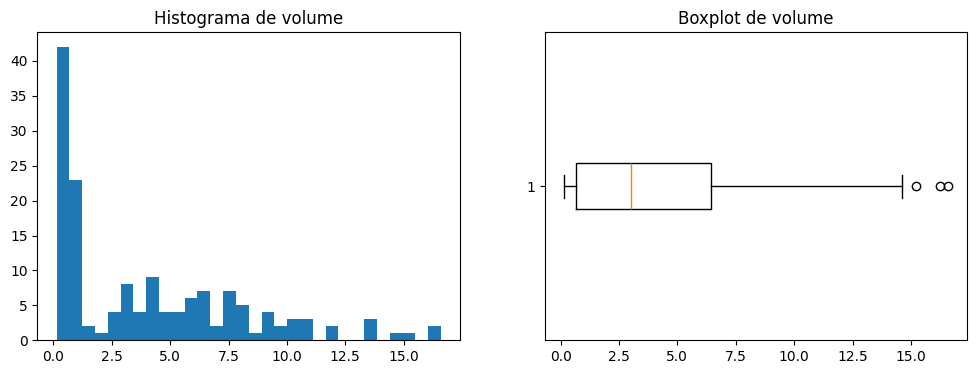

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['volume'].dropna(), bins=30)
plt.title('Histograma de volume')

plt.subplot(1,2,2)
plt.boxplot(df['volume'].dropna(), vert=False)
plt.title('Boxplot de volume')
plt.show()

Os gráficos sugerem fortemente que a série é não-estacionária, já que:
1.  *Há tendência de crescimento:* Temos uma tendência de alta no `volume` ao longo do período analisado, indicando que a média da série não é constante.
2.  *Variância inconstante:* As oscilações do `volume` aumentam conforme o nível da série sobe, com vales e picos mais distantes.

### Análise da Série Diferenciada

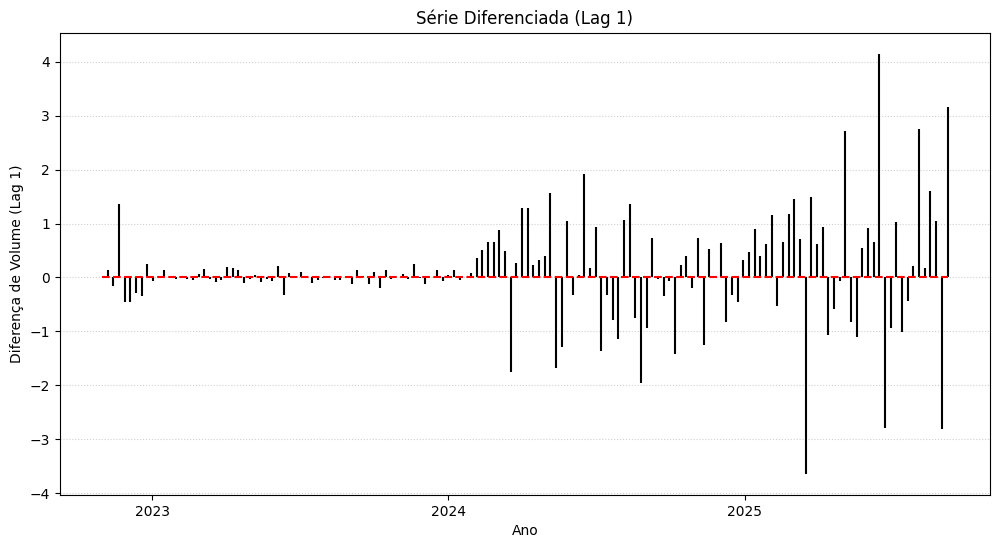

In [50]:
# Diferenciação (Lag 1)
df['volume_diff'] = np.where(df['volume'].diff(1) != np.nan, df['volume'].diff(1), 0)

plt.figure(figsize=(12, 6))

(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

A série diferenciada (Lag 1) mostra que os valores ainda apresentam flutuações grandes ao longo do tempo, com oscilações que parecem se intensificar nos períodos mais recentes. Apesar da diferenciação, não há uma estabilização em torno da linha zero, o que indica que a série ainda pode carregar estruturas de dependência temporal não removidas apenas pela primeira diferenciação.

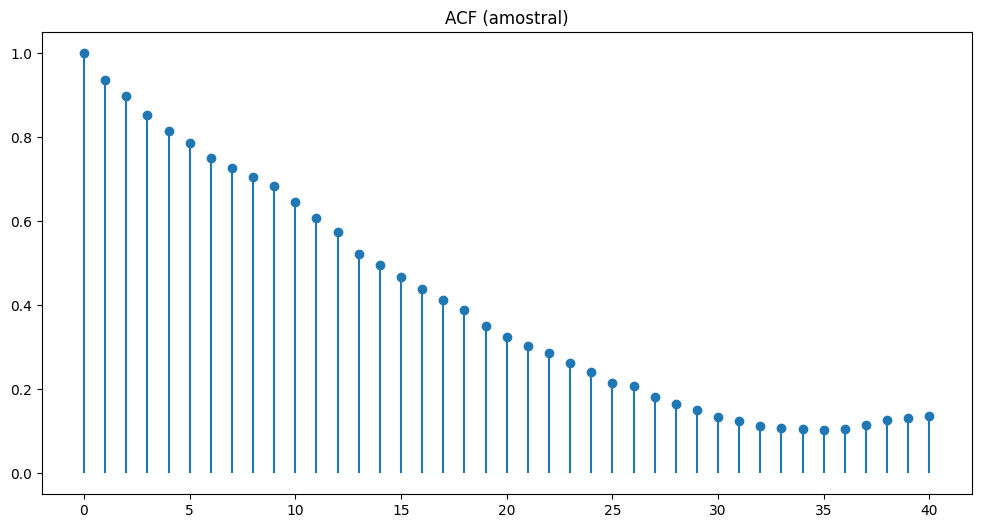

In [51]:
lag_acf = acf(df['volume'].dropna(), nlags=40, fft=False)
plt.figure(figsize=(12,6))
plt.stem(range(len(lag_acf)), lag_acf, basefmt=' ')
plt.title('ACF (amostral)')
plt.show()

Reforçando essa interpretação, o gráfico da ACF exibe uma decadência lenta e gradual das autocorrelações ao longo das defasagens, o que é característica de séries com forte dependência e possível não estacionariedade.

Dessa forma, pode ser necessária a aplicação de mais diferenciações ou transformações adicionais para garantir a estacionariedade antes da modelagem (por exemplo, em ARIMA).

### Usando Log-Transformação: Será?

O logaritmo estabiliza a variância, fazendo com que a série se comporte de forma mais homogênea e facilitando a modelagem, especialmente em séries com tendência de crescimento exponencial. Como nossa série tem crescimento aparentemente exponencial, podemos fazer um teste de resíduo após a mudança e observar se vale a pena utilizar uma log-transformação.

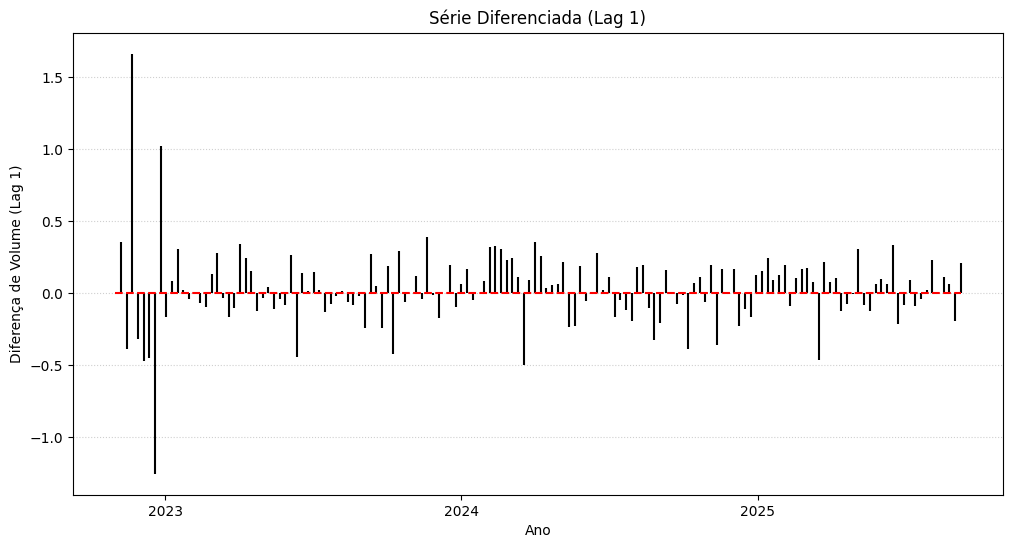

In [52]:
df['volume_log'] = np.log(df['volume']) 
df['volume_log_diff'] = np.where(df['volume_log'].diff(1) != np.nan, df['volume_log'].diff(1), 0)

#print(df.head())
plt.figure(figsize=(12, 6))
(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_log_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

Ao ver o gráfico da nova série (após a Log-Transformação e a Diferenciação), as flutuações de volume se tornaram mais regulares e o gráfico PACF mostrou correlações fracas (poucas colunas fora do range de confiança). Assim, podemos usar essa transformação para fazer nossa modelagem.

Para confirmar nossa análise visual, aplicamos o teste de Dickey-Fuller Aumentado (ADF), que testa a hipótese nula de que uma raiz unitária está presente na série (indicando não estacionariedade).

--- Teste de Estacionariedade (ADF) ---
Série Original - Estatística ADF: 1.0022
Série Original - p-valor: 0.9943

Série Log-Diferenciada - Estatística ADF: -14.6189
Série Log-Diferenciada - p-valor: 0.0000


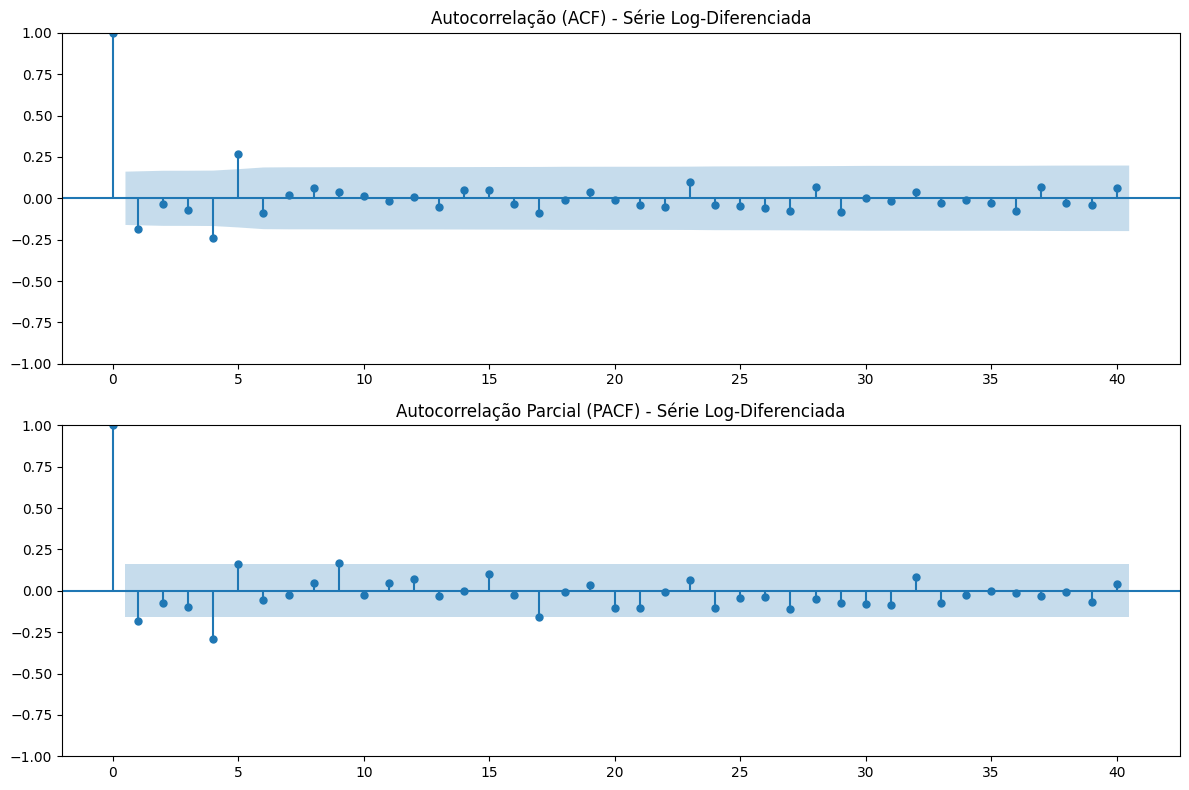

In [53]:
# teste Dickey-Fuller Aumentado na série original
print('--- Teste de Estacionariedade (ADF) ---')
result_adf_original = adfuller(df['volume'].dropna())
print(f'Série Original - Estatística ADF: {result_adf_original[0]:.4f}')
print(f'Série Original - p-valor: {result_adf_original[1]:.4f}')
# o p-valor alto confirma que a série original não é estacionária.

# teste Dickey-Fuller Aumentado na série log-diferenciada
result_adf_log_diff = adfuller(df['volume_log_diff'].dropna().iloc[1:]) # iloc[1:] para remover o primeiro NaN/zero
print(f'\nSérie Log-Diferenciada - Estatística ADF: {result_adf_log_diff[0]:.4f}')
print(f'Série Log-Diferenciada - p-valor: {result_adf_log_diff[1]:.4f}')
# um p-valor baixo (ex: < 0.05) indicará que a série se tornou estacionária.


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
sm.graphics.tsa.plot_acf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax1)
ax1.set_title('Autocorrelação (ACF) - Série Log-Diferenciada')

# PACF
sm.graphics.tsa.plot_pacf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF) - Série Log-Diferenciada')

plt.tight_layout()
plt.show()

-   **Série Original:** O teste resultou em um p-valor de `0.9943`, muito acima do nível de significância de 0.05. Portanto, não podemos rejeitar a hipótese nula, confirmando estatisticamente que a série `volume` é não-estacionária.
-   **Série Log-Diferenciada:** Após aplicar a transformação logarítmica (para estabilizar a variância) e a primeira diferenciação (para remover a tendência), o teste ADF resultou em um p-valor de `0.00`, indicando que a série transformada é estacionária.

As flutuações da série transformada tornaram-se visivelmente mais regulares. Analisando seus gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF), observamos que a maioria dos lags cai rapidamente dentro do intervalo de confiança. Isso sugere que a transformação foi eficaz em remover a maior parte da estrutura de dependência temporal, tornando a série adequada para modelagem. Adotaremos a transformação logarítmica como um passo padrão antes de ajustar nossos modelos de regressão.